## Part 3

The end goal of this project was to build a content based recommender system. The data for this project was scraped from IMDb website. During this journey of building a recommender system, I stumbled upon some interesting movie facts. I have partitioned this project in 3 jupyter notebooks. This notebook deals with data cleaning and the interesting movie facts.

## Importing necessary modules

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
% matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [298]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)
movies=pd.read_csv('movies_data.csv')
movies.head()

,Unnamed: 0,Unnamed: 0.1,certificate,directors,duration,genre,gross,metascore,movie,rating,stars,vote,year
0,0,0,R,Susanne Bier,124 min,"\nDrama, Horror, Sci-Fi",NaN,52.0,Bird Box,6.7,"Sandra Bullock, Trevante Rhodes, John Malkovic...",125127,(2018)
1,1,1,PG-13,James Wan,143 min,"\nAction, Adventure, Fantasy","260,024,160",55.0,Aquaman,7.5,"Jason Momoa, Amber Heard, Willem Dafoe, Patric...",114391,(2018)
2,2,2,TV-MA,David Slade,90 min,"\nDrama, Mystery, Sci-Fi",NaN,NaN,Black Mirror: Bandersnatch,7.6,"Fionn Whitehead, Craig Parkinson, Alice Lowe, ...",56440,(2018)
3,3,3,PG,"Bob Persichetti, Peter Ramsey, Rodney Rothman",117 min,"\nAnimation, Action, Adventure","133,978,231",87.0,Spider-Man: Into the Spider-Verse,8.7,"Shameik Moore, Jake Johnson, Hailee Steinfeld,...",67264,(2018)
4,4,4,PG,Rob Marshall,130 min,"\nComedy, Family, Fantasy","138,817,262",66.0,Mary Poppins Returns,7.3,"Emily Blunt, Lin-Manuel Miranda, Ben Whishaw, ...",23594,(2018)


I then checked the shape and the columns in the dataframe. As 'Unnamed: 0' had no use, I deleted that.

In [299]:
movies.shape

(48158, 13)

In [300]:
movies.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'certificate', 'directors', 'duration',
       'genre', 'gross', 'metascore', 'movie', 'rating', 'stars', 'vote',
       'year'],
      dtype='object')

In [301]:
movies.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1, inplace=True)
movies.columns

Index(['certificate', 'directors', 'duration', 'genre', 'gross', 'metascore',
       'movie', 'rating', 'stars', 'vote', 'year'],
      dtype='object')

Using the info method I found that there are 44624 entries missing in the 'gross' column, which is the maximum entries lacking for any feature. Also, it gave information about the datatypes of the respective features, which is crucial while dealing with the respective columns.

In [302]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48158 entries, 0 to 48157
Data columns (total 11 columns):
certificate    14978 non-null object
directors      46968 non-null object
duration       38960 non-null object
genre          46876 non-null object
gross          3546 non-null object
metascore      4775 non-null float64
movie          48158 non-null object
rating         29304 non-null float64
stars          45974 non-null object
vote           29321 non-null object
year           48158 non-null object
dtypes: float64(2), object(9)
memory usage: 4.0+ MB


## Data Cleaning

I began filling the missing values of the 'metascore' feature. As all its nonnull values are float we replace its null values with '0'. The minimum value exiting before filling nan is 1. 

In [303]:
movies['metascore'].min()

1.0

In [304]:
movies['metascore']=movies['metascore'].fillna(0)

Next we found that the year column has numeric year value combined with roman numbers. To solve that we sliced -5:-1 of the year string and then converted it into integer.

In [305]:
movies['year'].unique()

array(['(2018)', '(I) (2018)', '(III) (2018)', '(II) (2018)',
       '(V) (2018)', '(IV) (2018)', '(VIII) (2018)', '(VII) (2018)',
       '(XI) (2018)', '(VI) (2018)', '(IX) (2018)', '(XXI) (2018)',
       '(2017)', '(I) (2017)', '(II) (2017)', '(III) (2017)',
       '(IV) (2017)', '(VI) (2017)', '(V) (2017)', '(XII) (2017)',
       '(VIII) (2017)', '(XVI) (2017)', '(XV) (2017)', '(VII) (2017)',
       '(IX) (2017)', '(XI) (2017)', '(XIV) (2017)', '(X) (2017)',
       '(XX) (2017)', '(XXIV) (2017)', '(XIII) (2017)', '(IX) (2016)',
       '(2016)', '(I) (2016)', '(II) (2016)', '(V) (2016)',
       '(III) (2016)', '(IV) (2016)', '(VI) (2016)', '(VII) (2016)',
       '(XI) (2016)', '(VIII) (2016)', '(XIV) (2016)', '(XVI) (2016)',
       '(XII) (2016)', '(X) (2016)', '(XIII) (2016)', '(2015)',
       '(I) (2015)', '(II) (2015)', '(VI) (2015)', '(III) (2015)',
       '(IV) (2015)', '(VIII) (2015)', '(V) (2015)', '(VII) (2015)',
       '(XI) (2015)', '(IX) (2015)', '(X) (2015)', '(XII) (2015

In [306]:
movies['year']=movies['year'].str[-5:-1]
movies['year'].unique()

array(['2018', '2017', '2016', '2015', '2014', '2013', '2011', '2012',
       '2009', '2010'], dtype=object)

In [307]:
movies['year']=movies['year'].astype(int)

As indicated above by the info method, we found gross (the revenue generated by movie) to be reported as object. So, I first filled the missing value as 0 and then converted the dtattype to integer.

In [308]:
movies['gross']=movies['gross'].fillna('0')
movies['gross']=movies['gross'].str.replace(',','').astype(int)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48158 entries, 0 to 48157
Data columns (total 11 columns):
certificate    14978 non-null object
directors      46968 non-null object
duration       38960 non-null object
genre          46876 non-null object
gross          48158 non-null int64
metascore      48158 non-null float64
movie          48158 non-null object
rating         29304 non-null float64
stars          45974 non-null object
vote           29321 non-null object
year           48158 non-null int64
dtypes: float64(2), int64(2), object(7)
memory usage: 4.0+ MB


As seen above in the dataframe.head(), the dration is reported in a combination of numbers with 'min'. To get rid of 'min', I sliced the numbers out of duration. Then I filled the null values with 0.

In [309]:
movies['duration']=movies['duration'].str[:-4]
movies.head()

,certificate,directors,duration,genre,gross,metascore,movie,rating,stars,vote,year
0,R,Susanne Bier,124,"\nDrama, Horror, Sci-Fi",0,52.0,Bird Box,6.7,"Sandra Bullock, Trevante Rhodes, John Malkovic...",125127,2018
1,PG-13,James Wan,143,"\nAction, Adventure, Fantasy",260024160,55.0,Aquaman,7.5,"Jason Momoa, Amber Heard, Willem Dafoe, Patric...",114391,2018
2,TV-MA,David Slade,90,"\nDrama, Mystery, Sci-Fi",0,0.0,Black Mirror: Bandersnatch,7.6,"Fionn Whitehead, Craig Parkinson, Alice Lowe, ...",56440,2018
3,PG,"Bob Persichetti, Peter Ramsey, Rodney Rothman",117,"\nAnimation, Action, Adventure",133978231,87.0,Spider-Man: Into the Spider-Verse,8.7,"Shameik Moore, Jake Johnson, Hailee Steinfeld,...",67264,2018
4,PG,Rob Marshall,130,"\nComedy, Family, Fantasy",138817262,66.0,Mary Poppins Returns,7.3,"Emily Blunt, Lin-Manuel Miranda, Ben Whishaw, ...",23594,2018


In [310]:
movies['duration']=movies['duration'].fillna('0')
movies['duration'].isnull().any()

False

Next I had to convert duration into 'int', but it was showing error. The reason behind it was evident when I checked that 2 values are 4 digits and they had ',' in them. That needed to be removed and then I converted the dtype to 'int'.

In [311]:
movies['duration'].unique()

array(['124', '143', '90', '117', '130', '114', '119', '149', '116',
       '132', '134', '112', '141', '135', '136', '110', '133', '93',
       '128', '104', '140', '147', '120', '107', '111', '127', '152',
       '105', '103', '106', '118', '115', '101', '113', '86', '96', '102',
       '121', '100', '129', '158', '89', '122', '85', '94', '97', '125',
       '156', '91', '109', '139', '99', '108', '98', '95', '148', '92',
       '0', '123', '159', '160', '84', '126', '88', '164', '81', '83',
       '82', '80', '154', '79', '142', '77', '87', '74', '76', '71', '78',
       '169', '73', '70', '72', '137', '75', '180', '144', '60', '220',
       '62', '145', '138', '49', '67', '59', '19', '227', '155', '69',
       '65', '8', '12', '14', '150', '153', '50', '68', '55', '66', '25',
       '45', '21', '54', '15', '11', '38', '51', '52', '146', '183', '10',
       '63', '61', '64', '7', '165', '30', '5', '46', '182', '170', '40',
       '4', '20', '166', '47', '57', '13', '53', '6', '24', 

In [312]:
movies['duration']=movies['duration'].str.replace('1,100' , '1100')
movies['duration']=movies['duration'].str.replace('1,834' , '1834')
movies['duration']=movies['duration'].str.replace('1,559' , '1559')
movies['duration']=movies['duration'].str.replace('1,440' , '1440')
movies['duration']=movies['duration'].str.replace('5,460' , '5460')
movies['duration']=movies['duration'].str.replace('1,151' , '1151')
movies['duration']=movies['duration'].str.replace('1,669' , '1669')
movies['duration']=movies['duration'].str.replace('4,200' , '4200')
movies['duration']=movies['duration'].str.replace('1,800' , '1800')
movies['duration']=movies['duration'].str.replace('1,200' , '1200')
movies['duration'].unique()

array(['124', '143', '90', '117', '130', '114', '119', '149', '116',
       '132', '134', '112', '141', '135', '136', '110', '133', '93',
       '128', '104', '140', '147', '120', '107', '111', '127', '152',
       '105', '103', '106', '118', '115', '101', '113', '86', '96', '102',
       '121', '100', '129', '158', '89', '122', '85', '94', '97', '125',
       '156', '91', '109', '139', '99', '108', '98', '95', '148', '92',
       '0', '123', '159', '160', '84', '126', '88', '164', '81', '83',
       '82', '80', '154', '79', '142', '77', '87', '74', '76', '71', '78',
       '169', '73', '70', '72', '137', '75', '180', '144', '60', '220',
       '62', '145', '138', '49', '67', '59', '19', '227', '155', '69',
       '65', '8', '12', '14', '150', '153', '50', '68', '55', '66', '25',
       '45', '21', '54', '15', '11', '38', '51', '52', '146', '183', '10',
       '63', '61', '64', '7', '165', '30', '5', '46', '182', '170', '40',
       '4', '20', '166', '47', '57', '13', '53', '6', '24', 

In [313]:
movies['duration']=movies['duration'].astype(int)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48158 entries, 0 to 48157
Data columns (total 11 columns):
certificate    14978 non-null object
directors      46968 non-null object
duration       48158 non-null int64
genre          46876 non-null object
gross          48158 non-null int64
metascore      48158 non-null float64
movie          48158 non-null object
rating         29304 non-null float64
stars          45974 non-null object
vote           29321 non-null object
year           48158 non-null int64
dtypes: float64(2), int64(3), object(6)
memory usage: 4.0+ MB


Next, I filled the null values in the 'certificate' column. As can be seen, initially there were 1291 'Not Rated' values and 127 'Unrated'. Upon filling the missing values with 'Unrated', the number of 'Unrated' increased from 127 to 6645. In order to avoid duplicate name, I combined both 'Unrated' and 'Not Rated' into one. 

In [314]:
movies['certificate'].isnull().any()

True

In [315]:
movies['certificate'].value_counts()

Not Rated    6840
R            3442
PG-13        1603
Unrated       799
PG            768
TV-MA         620
TV-14         434
TV-PG         197
G             142
TV-G           84
TV-Y           12
TV-Y7          11
Approved        9
NC-17           5
M               3
E               2
Open            2
AO              2
X               1
MA-17           1
C               1
Name: certificate, dtype: int64

In [316]:
movies['certificate']=movies['certificate'].fillna('Unrated')
movies['certificate'].isnull().any()

False

In [317]:
movies['certificate'].value_counts()

Unrated      33979
Not Rated     6840
R             3442
PG-13         1603
PG             768
TV-MA          620
TV-14          434
TV-PG          197
G              142
TV-G            84
TV-Y            12
TV-Y7           11
Approved         9
NC-17            5
M                3
E                2
Open             2
AO               2
X                1
MA-17            1
C                1
Name: certificate, dtype: int64

In [318]:
movies['certificate']=movies['certificate'].str.replace('Not Rated','Unrated')
movies['certificate'].value_counts()

Unrated     40819
R            3442
PG-13        1603
PG            768
TV-MA         620
TV-14         434
TV-PG         197
G             142
TV-G           84
TV-Y           12
TV-Y7          11
Approved        9
NC-17           5
M               3
E               2
AO              2
Open            2
X               1
MA-17           1
C               1
Name: certificate, dtype: int64

Next I found that the 'genre' column had a lot of empty space and '\n'. These needed to be stripped and the null values were filled with ''. The reason filling missing values will become clear later.

In [319]:
movies['genre']=movies['genre'].str.rstrip()
movies['genre'].unique()

array(['\nDrama, Horror, Sci-Fi', '\nAction, Adventure, Fantasy',
       '\nDrama, Mystery, Sci-Fi', '\nAnimation, Action, Adventure',
       '\nComedy, Family, Fantasy', '\nAction, Adventure, Sci-Fi',
       '\nBiography, Comedy, Drama', '\nAdventure, Comedy, Crime',
       '\nCrime, Drama, Thriller', '\nBiography, Drama, Music',
       '\nAnimation, Adventure, Comedy', '\nCrime, Drama, Mystery',
       '\nDrama', '\nAction, Sci-Fi', '\nComedy, Crime, Drama',
       '\nDrama, Music, Romance', '\nDrama, Horror, Mystery',
       '\nAdventure, Family, Fantasy', '\nComedy, Drama, Musical',
       '\nAdventure, Drama, Fantasy', '\nBiography, Drama, History',
       '\nAction, Adventure, Thriller', '\nComedy, Romance',
       '\nAction, Adventure, Horror', '\nComedy',
       '\nCrime, Mystery, Sci-Fi', '\nBiography, Crime, Drama',
       '\nCrime, Drama, Horror', '\nDrama, Sport', '\nCrime, Drama',
       '\nHorror, Thriller', '\nAdventure, Drama, Horror',
       '\nAction, Adventure, Comed

In [320]:
movies['genre']=movies['genre'].str.strip('\n')
movies['genre'].unique()

array(['Drama, Horror, Sci-Fi', 'Action, Adventure, Fantasy',
       'Drama, Mystery, Sci-Fi', 'Animation, Action, Adventure',
       'Comedy, Family, Fantasy', 'Action, Adventure, Sci-Fi',
       'Biography, Comedy, Drama', 'Adventure, Comedy, Crime',
       'Crime, Drama, Thriller', 'Biography, Drama, Music',
       'Animation, Adventure, Comedy', 'Crime, Drama, Mystery', 'Drama',
       'Action, Sci-Fi', 'Comedy, Crime, Drama', 'Drama, Music, Romance',
       'Drama, Horror, Mystery', 'Adventure, Family, Fantasy',
       'Comedy, Drama, Musical', 'Adventure, Drama, Fantasy',
       'Biography, Drama, History', 'Action, Adventure, Thriller',
       'Comedy, Romance', 'Action, Adventure, Horror', 'Comedy',
       'Crime, Mystery, Sci-Fi', 'Biography, Crime, Drama',
       'Crime, Drama, Horror', 'Drama, Sport', 'Crime, Drama',
       'Horror, Thriller', 'Adventure, Drama, Horror',
       'Action, Adventure, Comedy', 'Action, Drama, Thriller',
       'Drama, Mystery, Thriller', 'Action

In [321]:
movies['genre']=movies['genre'].fillna('Unknown')
movies['genre'].isnull().any()

False

Next, I filled missing values for directors and stars

In [322]:
movies['directors']=movies['directors'].fillna('Unknown')
movies['directors'].isnull().any()

False

In [323]:
movies['stars']=movies['stars'].fillna('Unknown')
movies['stars'].isnull().any()

False

In [324]:
movies['vote'].unique()

array(['125127', '114391', '56440', ..., '1063', '7,200', '2,200'],
      dtype=object)

In [325]:
movies['vote']=movies['vote'].str.replace(',','')
movies['vote'].unique()

array(['125127', '114391', '56440', ..., '1299', '669', '1063'],
      dtype=object)

In [326]:
movies['vote']=movies['vote'].fillna('0').astype(int)
movies['vote'].isnull().any()

False

In [327]:
movies['vote'].value_counts()

0          18837
6           1003
7            877
5            789
8            744
9            629
10           573
11           526
13           496
12           467
14           419
15           407
16           360
19           323
17           322
18           306
20           273
21           262
22           259
24           234
23           226
25           201
28           192
26           188
27           185
33           172
30           171
31           166
29           160
32           158
34           140
37           138
38           136
35           131
40           128
39           122
36           117
46           108
47           104
44           102
43           102
41           102
45           101
49           100
52            89
53            89
42            89
61            85
55            84
51            79
69            79
48            78
68            77
50            76
60            74
67            74
64            70
76            70
56            

Next, I  filled missing values for 'rating' column. The minimum rating anyone can give to any movie in IMDb is 1. 

In [328]:
movies['rating']=movies['rating'].fillna(0)
movies['rating'].isnull().any()

False

Next, I rearranged the columns and sorted them according to year and rating.

In [329]:
movies=movies[['movie','year','genre','duration','certificate','directors','stars','rating','metascore','vote','gross']]
movies=movies.sort_values(by=['year','rating'],ascending=False)
movies.head(10)

,movie,year,genre,duration,certificate,directors,stars,rating,metascore,vote,gross
2319,Hassan - The image of our common pain,2018,"Drama, Family",111,Unrated,Emaan,"Leena Alam, Haroon Azizi, Hakim Diljo, Emaan",10.0,0.0,5,0
1528,Halt: The Motion Picture,2018,Drama,110,Unrated,Jezar Riches,"Harley Wallen, Andrew Dawe-Collins, Dennis Doy...",9.9,0.0,29,0
910,"Onyx, Kings of the Grail",2018,History,0,Unrated,Roberto Girault,"Jim Caviezel, Maria de Medeiros, Anthony Howel...",9.8,0.0,5,0
1562,Mr. Presto,2018,Comedy,111,Unrated,Joey Kneiser,"Shane Spresser, Eric Giles, Jon Latham, Spence...",9.8,0.0,5,0
1727,Green on Green,2018,"Adventure, Comedy",90,Unrated,Tom Knoblauch,"Rachel Dinan, Leah Cardenas, David Remus, Drew...",9.8,0.0,5,0
2459,Colours Of Life,2018,Drama,0,Unrated,Prakash Bharadwaj,"Priyanshu Chatterjee, Patrali Chattopdhyay, Bh...",9.8,0.0,8,0
2791,Restore,2018,Family,65,Unrated,Tyler Sansom,"Lea Hutton Beasmore, Maddie Burns, Brandon Fel...",9.8,0.0,16,0
2609,Jewtah,2018,"Comedy, Drama",81,Unrated,Cameron Bossert,"Jeremy Rishe, Amy Lynn Stewart, Robert Scott S...",9.7,0.0,14,0
2676,Red Call,2018,Drama,85,Unrated,Steve Gough,"Emma Spearing, Christopher Tajah, Jason Plessa...",9.7,0.0,11,0
641,Hex,2018,"Horror, Thriller",85,Unrated,Rudolf Buitendach,"Ross McCall, Jenny Boyd, Kelly Blatz, Adrian H...",9.6,0.0,1070,0


In [330]:
movies=movies.reset_index()
movies.head()

,index,movie,year,genre,duration,certificate,directors,stars,rating,metascore,vote,gross
0,2319,Hassan - The image of our common pain,2018,"Drama, Family",111,Unrated,Emaan,"Leena Alam, Haroon Azizi, Hakim Diljo, Emaan",10.0,0.0,5,0
1,1528,Halt: The Motion Picture,2018,Drama,110,Unrated,Jezar Riches,"Harley Wallen, Andrew Dawe-Collins, Dennis Doy...",9.9,0.0,29,0
2,910,"Onyx, Kings of the Grail",2018,History,0,Unrated,Roberto Girault,"Jim Caviezel, Maria de Medeiros, Anthony Howel...",9.8,0.0,5,0
3,1562,Mr. Presto,2018,Comedy,111,Unrated,Joey Kneiser,"Shane Spresser, Eric Giles, Jon Latham, Spence...",9.8,0.0,5,0
4,1727,Green on Green,2018,"Adventure, Comedy",90,Unrated,Tom Knoblauch,"Rachel Dinan, Leah Cardenas, David Remus, Drew...",9.8,0.0,5,0


In [331]:
movies=movies.drop('index',axis=1)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48158 entries, 0 to 48157
Data columns (total 11 columns):
movie          48158 non-null object
year           48158 non-null int64
genre          48158 non-null object
duration       48158 non-null int64
certificate    48158 non-null object
directors      48158 non-null object
stars          48158 non-null object
rating         48158 non-null float64
metascore      48158 non-null float64
vote           48158 non-null int64
gross          48158 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 4.0+ MB


In [332]:
 movies.to_csv('movies_2.csv')

## Analysis

I then started exploring interesting facts about movies. To begin with,I checked the numbers of movies releasedper year. From the plot it is clear that there is a growing trend in number of movies released per year, with maximum movies released in 2018 in the last 10 years.

In [333]:
 movies.groupby('year')['movie'].count()

year
2009    3778
2010    3759
2011    4222
2012    4420
2013    4696
2014    4911
2015    5019
2016    5387
2017    5887
2018    6079
Name: movie, dtype: int64

Text(0.5,1,'Movies made per year')

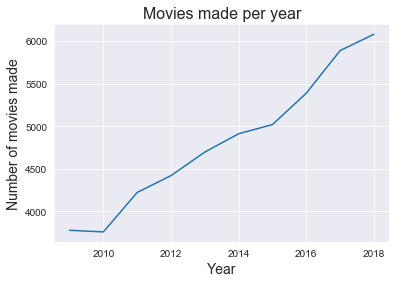

In [241]:
movies.groupby('year')['movie'].count().plot(kind='line')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of movies made', fontsize=14)
plt.title('Movies made per year', fontsize=16)

Next, I explored the most popular words in movie titles. No doubt the most popular word in movie titles came up to be 'Love'..an intrinsic and unavoidable theme across cultures and age :) It is followed by 'Movie','Night','Dead','Life', 'Man' .

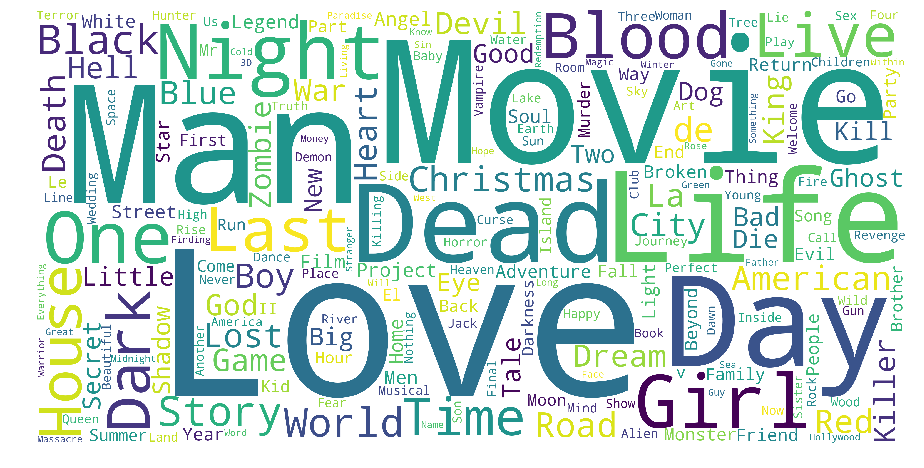

In [189]:
title_corpus = ' '.join(movies['movie'])
title_wordcloud = WordCloud( stopwords=STOPWORDS,background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Next, I checked that most popular movie genre. Drama seems to be a popular theme here.

In [217]:
movies['genre']=movies['genre'].str.replace('Unknown','')

In [218]:
movies['genre']=movies['genre'].str.split(',')
movies.head()

,movie,year,genre,duration,certificate,directors,stars,rating,metascore,vote,gross
0,Hassan - The image of our common pain,2018,"[Drama, Family]",111,Unrated,Emaan,"Leena Alam, Haroon Azizi, Hakim Diljo, Emaan",10.0,0.0,5,0
1,Halt: The Motion Picture,2018,[Drama],110,Unrated,Jezar Riches,"Harley Wallen, Andrew Dawe-Collins, Dennis Doy...",9.9,0.0,29,0
2,"Onyx, Kings of the Grail",2018,[History],0,Unrated,Roberto Girault,"Jim Caviezel, Maria de Medeiros, Anthony Howel...",9.8,0.0,5,0
3,Mr. Presto,2018,[Comedy],111,Unrated,Joey Kneiser,"Shane Spresser, Eric Giles, Jon Latham, Spence...",9.8,0.0,5,0
4,Green on Green,2018,"[Adventure, Comedy]",90,Unrated,Tom Knoblauch,"Rachel Dinan, Leah Cardenas, David Remus, Drew...",9.8,0.0,5,0


In [219]:
def attach (x):
    y=' '.join(x)
    return y
movies['genre2']=movies['genre'].apply(attach)

In [220]:
genre_corpus = ' '.join(' '.join(movies['genre2']).split())
dicti=Counter(genre_corpus.split())
p=pd.Series(dicti)
x=p.sort_values(ascending=False)
x.head(15)

Drama        22678
Comedy       12802
Horror        7648
Thriller      7603
Action        5349
Romance       4401
Crime         3752
Adventure     2795
Mystery       2763
Sci-Fi        2503
Fantasy       1977
Family        1961
Animation     1259
Music         1256
Biography      986
dtype: int64

Text(0.5,1,'Movie genre')

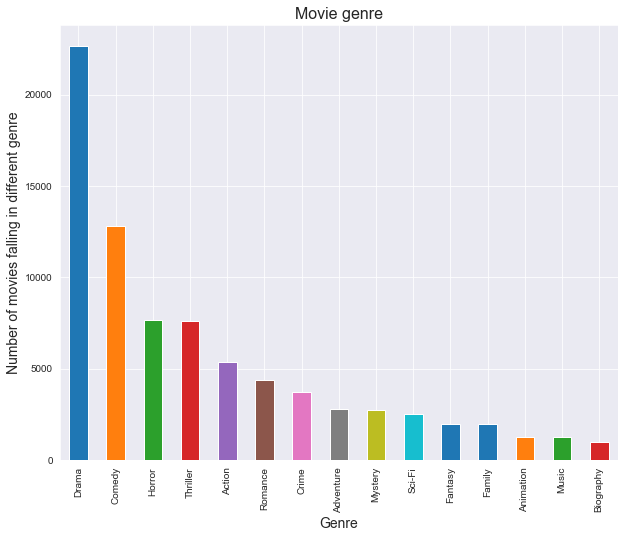

In [221]:
fig, ax= plt.subplots(figsize=(10,8))
x.head(15).plot(kind='bar')
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Number of movies falling in different genre', fontsize=14)
plt.title('Movie genre', fontsize=16)

Next comes the maximum grosser in the available data. It is 2015 flick: 'Star Wars: The Force Awaken'. This movie earned a revenue of over 936 million(in $).

In [222]:
movies['gross'].max()
movies.loc[movies['gross']==movies['gross'].max()]

,movie,year,genre,duration,certificate,directors,stars,rating,metascore,vote,gross,genre2
17588,Star Wars: The Force Awakens,2015,"[Action, Adventure, Fantasy]",136,PG-13,J.J. Abrams,"Daisy Ridley, John Boyega, Oscar Isaac, Domhna...",8.0,81.0,766401,936662225,Action Adventure Fantasy


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

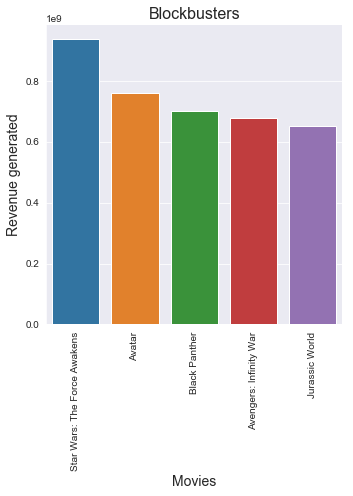

In [223]:
#ax.ticklabel_format(style='plain')
a=movies[movies['gross']!=0]
b=a.sort_values('gross', ascending=False).head(5)
sns.catplot(x='movie', y='gross', kind='bar', data=b)
plt.xlabel('Movies',fontsize=14)
plt.ylabel('Revenue generated',fontsize=14)
plt.title('Blockbusters',fontsize=16)
plt.xticks(rotation=90)

The least earner among the movies (for which we have revenue data) is Veer!

In [224]:
c=a.sort_values('gross', ascending=True).head(1)
c

,movie,year,genre,duration,certificate,directors,stars,rating,metascore,vote,gross,genre2
32385,Veer!,2012,"[Comedy, Drama, Romance]",87,Unrated,Patrick Barry,"Jesse Gay, Erin Cline, James Nguyen, Corsica W...",7.6,0.0,66,85,Comedy Drama Romance


In [287]:
movies[movies['metascore']==100]

,movie,year,genre,duration,certificate,directors,stars,rating,metascore,vote,gross,genre2
22686,Boyhood,2014,[Drama],165,R,Richard Linklater,"Ellar Coltrane, Patricia Arquette, Ethan Hawke...",7.9,100.0,310618,25379975,Drama


There are 9 movies with ratings of 10. The most recent in this list is 2018 released 'Hassan - The image of our common pain'. As expected this movies are rated by only a few individuals, thus a rating of 10.

In [225]:
movies.loc[movies['rating']==movies['rating'].max()]

,movie,year,genre,duration,certificate,directors,stars,rating,metascore,vote,gross,genre2
0,Hassan - The image of our common pain,2018,"[Drama, Family]",111,Unrated,Emaan,"Leena Alam, Haroon Azizi, Hakim Diljo, Emaan",10.0,0.0,5,0,Drama Family
6079,Desierto en tu mente,2017,"[Comedy, Drama, Fantasy]",63,Unrated,Marta Grimalt,"Craig Amromin, Bruna Blavia, Maria Amelia Cana...",10.0,0.0,5,0,Comedy Drama Fantasy
6080,September Rayne,2017,[Drama],0,Unrated,Cassandra Bell,"Harold Dennis, Terry King, Anah Ambuchi, Peter...",10.0,0.0,5,0,Drama
11966,Emergency Landing,2016,[Drama],0,Unrated,Rodney L. Cherry,"Renee Carillo, Brian Fecteau, Mylarah Silverne...",10.0,0.0,7,0,Drama
11967,Somewhere Over That Rainbow,2016,[Drama],75,Unrated,Rhiannon Williams,"Ajay Banks, Moise Capalb, Claudine Dearn, Josh...",10.0,0.0,6,0,Drama
17353,The Weekend Warriors,2015,[Comedy],0,Unrated,Myster DL,"Joey Barbieri, Sunny Black, Michael Claridge, ...",10.0,0.0,5,0,Comedy
22372,The Wizard of OZcar,2014,"[Family, Fantasy]",22,Unrated,Varta Torossian,"Barry James Montoya II, I. Elijah Baughman, El...",10.0,0.0,5,0,Family Fantasy
22373,Stalemate,2014,[Drama],60,Unrated,John C. Koch,"William H. Frey III, Nadia Kiyatkina, Catarina...",10.0,0.0,6,0,Drama
27283,The Bad Coming Back,2013,[Drama],89,Unrated,Esteban Gunn,"Carl Silva, Chris Kato, Josh Berg, Shaun Fletcher",10.0,0.0,5,0,Drama


The longest movie in the list is 91hour long 'London EC1'. According to IMDb '[London EC1] A compilation of short films showing an intriguing mix of diverse film genres, featuring unique characters in stories full of mystery, fun and the dark side of love'. 

In [226]:
movies[movies['duration']==movies['duration'].max()]

,movie,year,genre,duration,certificate,directors,stars,rating,metascore,vote,gross,genre2
21166,London EC1,2015,"[Comedy, Drama, Mystery]",5460,Unrated,Erdogan Gilgil,"Pablo A. Alonso, Tilly Bulgar, Grace Cookey-Ga...",0.0,0.0,0,0,Comedy Drama Mystery


Next, I plotted the top 10 longest movies. Most of these movies are made for exhibition purposes and are not shown in movie theatres. 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

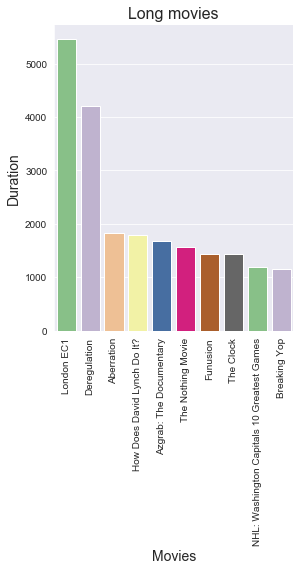

In [227]:
d=movies.sort_values('duration',ascending=False).head(10)
sns.catplot(x='movie', y='duration', kind='bar', data=d, palette='Accent')
plt.xlabel('Movies',fontsize=14)
plt.ylabel('Duration',fontsize=14)
plt.title('Long movies',fontsize=16)
plt.xticks(rotation=90)

Next, I plotted 20 shortest movies.11 of them are just 1 min long

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

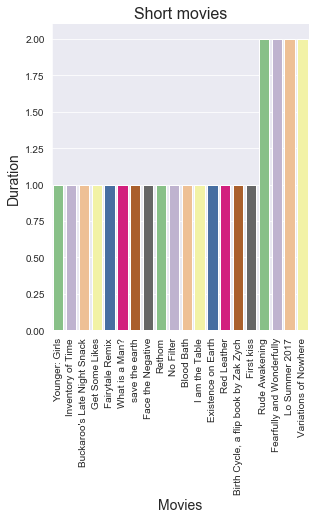

In [228]:
e=movies[movies['duration']!= 0]
f=e.sort_values('duration',ascending=True).head(20)
sns.catplot(x='movie', y='duration', kind='bar', data=f, palette="Accent")
plt.xlabel('Movies',fontsize=14)
plt.ylabel('Duration',fontsize=14)
plt.title('Short movies',fontsize=16)
plt.xticks(rotation=90)

The most highly voted movie is Inception. It is followed by 'Out of Order', 'The Dark Knight Rises', 'interstellar' and 'Django Unchained'. While there are number of movies which are not rated in IMDb website. Other than that, the minimum number of votes for rated movies is 5 and there is a list of movies in this category such as 'Hassan-The image of our common pain' , 'Luka' to name a few.

Text(0.5,1,'Highly voted movies')

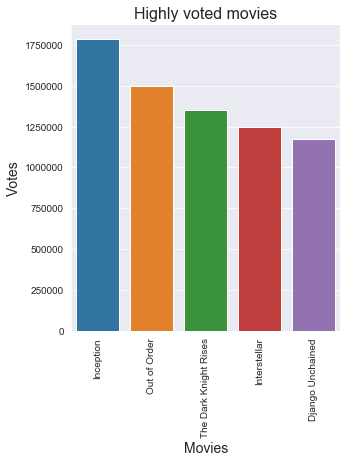

In [229]:
g=movies[movies['vote']!= 0]
h=g.sort_values('vote',ascending=False).head(5)
sns.catplot(x='movie', y='vote', data=h, kind='bar')
plt.xticks(rotation=90)
plt.xlabel('Movies',fontsize=14)
plt.ylabel('Votes',fontsize=14)
plt.title('Highly voted movies',fontsize=16)

In [230]:
i=movies[movies['directors']!='Unknown']

In [231]:
i['directors']=i['directors'].str.split(',')
i['num_dir']=i['directors'].apply(len)
i.head()

,movie,year,genre,duration,certificate,directors,stars,rating,metascore,vote,gross,genre2,num_dir
0,Hassan - The image of our common pain,2018,"[Drama, Family]",111,Unrated,[Emaan],"Leena Alam, Haroon Azizi, Hakim Diljo, Emaan",10.0,0.0,5,0,Drama Family,1
1,Halt: The Motion Picture,2018,[Drama],110,Unrated,[Jezar Riches],"Harley Wallen, Andrew Dawe-Collins, Dennis Doy...",9.9,0.0,29,0,Drama,1
2,"Onyx, Kings of the Grail",2018,[History],0,Unrated,[Roberto Girault],"Jim Caviezel, Maria de Medeiros, Anthony Howel...",9.8,0.0,5,0,History,1
3,Mr. Presto,2018,[Comedy],111,Unrated,[Joey Kneiser],"Shane Spresser, Eric Giles, Jon Latham, Spence...",9.8,0.0,5,0,Comedy,1
4,Green on Green,2018,"[Adventure, Comedy]",90,Unrated,[Tom Knoblauch],"Rachel Dinan, Leah Cardenas, David Remus, Drew...",9.8,0.0,5,0,Adventure Comedy,1


In [143]:
#i[i['num_dir']==2]

Interesting fact: Although, majority of the movies are directed by single directors. There are movies directed by 2, 3, 4, 5,6,7,8,9,10...even upto 81 directors. No doubt it took 81 directors to direct 'World of Death' as its a horror flick!

In [232]:
i['num_dir'].value_counts()

1     42304
2      3750
3       430
4       132
5        80
6        53
7        39
8        34
10       33
9        26
11       16
12       14
13        9
14        6
20        5
15        4
31        3
18        3
22        2
24        2
26        2
27        2
28        2
33        2
39        1
40        1
46        1
41        1
30        1
16        1
17        1
81        1
19        1
51        1
25        1
59        1
29        1
61        1
32        1
Name: num_dir, dtype: int64

In [233]:
i[i['num_dir']==81]

,movie,year,genre,duration,certificate,directors,stars,rating,metascore,vote,gross,genre2,num_dir
12865,World of Death,2016,"[Comedy, Horror, Sci-Fi]",142,Unrated,"[Allan Harvey, Brian Lockyer, Steven Payne, ...","Brandon Hunt, Morgan Finley King, Jeremy Koern...",7.0,0.0,28,0,Comedy Horror Sci-Fi,81


For further analysis, I needed genre not be in a list but needed directrors to be in a list in the movies dataframe therefore, I performed the following data manipulation.

In [234]:
i=i.drop('genre', axis=1)
i['genre']=i['genre2']
i=i.drop('genre2', axis=1)
i.head(1)

,movie,year,duration,certificate,directors,stars,rating,metascore,vote,gross,num_dir,genre
0,Hassan - The image of our common pain,2018,111,Unrated,[Emaan],"Leena Alam, Haroon Azizi, Hakim Diljo, Emaan",10.0,0.0,5,0,1,Drama Family


Next, I needed to explode the directors list and make individual rows for directors such that if multiple directors have directed a single movie then I can get each director with its own row with the movie details.

In [147]:
movies_=[]
years_=[]
genres_=[]
certificates_=[]
star_=[]
metascores_=[]
votes_=[]
duration_=[]
rating_=[]
director_=[]
gross_=[]
for _, row in i.iterrows():
    #print(row)
    moviex=row.movie
    yearx=row.year
    genrex=row.genre
    certificatex=row.certificate
    starsx=row.stars
    ratingx=row.rating
    metascorex=row.metascore
    votex=row.vote
    durationx=row.duration
    grossx=row.gross
    for director in row.directors:
        movies_.append(moviex)
        years_.append(yearx)
        genres_.append(genrex)
        certificates_.append(certificatex)
        star_.append(starsx)
        rating_.append(ratingx)
        metascores_.append(metascorex)
        votes_.append(votex)
        gross_.append(grossx)
        duration_.append(durationx)
        director_.append(director)

fun=pd.DataFrame({'movie':movies_,'year':years_,'certificate':certificates_,'duration':duration_, 'genre':genres_,'rating':rating_,'vote':votes_, 'directors':director_, 'stars':star_,'metascore':metascores_,'gross':gross_})
fun.head()

,certificate,directors,duration,genre,gross,metascore,movie,rating,stars,vote,year
0,Unrated,Emaan,111,Drama Family,0,0.0,Hassan - The image of our common pain,10.0,"Leena Alam, Haroon Azizi, Hakim Diljo, Emaan",5,2018
1,Unrated,Jezar Riches,110,Drama,0,0.0,Halt: The Motion Picture,9.9,"Harley Wallen, Andrew Dawe-Collins, Dennis Doy...",29,2018
2,Unrated,Roberto Girault,0,History,0,0.0,"Onyx, Kings of the Grail",9.8,"Jim Caviezel, Maria de Medeiros, Anthony Howel...",5,2018
3,Unrated,Joey Kneiser,111,Comedy,0,0.0,Mr. Presto,9.8,"Shane Spresser, Eric Giles, Jon Latham, Spence...",5,2018
4,Unrated,Tom Knoblauch,90,Adventure Comedy,0,0.0,Green on Green,9.8,"Rachel Dinan, Leah Cardenas, David Remus, Drew...",5,2018


In [148]:
fun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55207 entries, 0 to 55206
Data columns (total 11 columns):
certificate    55207 non-null object
directors      55207 non-null object
duration       55207 non-null int64
genre          55207 non-null object
gross          55207 non-null int64
metascore      55207 non-null float64
movie          55207 non-null object
rating         55207 non-null float64
stars          55207 non-null object
vote           55207 non-null int64
year           55207 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 4.6+ MB


I was interested in lnowing how many director are there in this list..And the number is 40557

In [149]:
fun['directors'].nunique()

40557

Next, I checked for the most prolific directors, the ones who direct movies like machines...Omer Pasha tops the charts as he has directed over 59 movies, followed by Larry Rosen, David DeCoteau, Michael Fredianelli, Paul T.T. Easter

In [150]:
fun.groupby('directors')['movie'].count().sort_values(ascending=False)

directors
Omer Pasha                          59
Larry Rosen                         41
David DeCoteau                      34
Michael Fredianelli                 32
Paul T.T. Easter                    28
 Tony Newton                        24
Dustin Ferguson                     22
Mickey Reece                        22
Creep Creepersin                    21
 Jason Impey                        20
Christopher Forbes                  20
Curtis Everitt                      20
Evan Tramel                         19
Vadim Starov                        19
Manny Velazquez                     19
Tyler Perry                         18
 Sam Mason-Bell                     18
Jared Cohn                          18
Mark Polonia                        17
Scout Tafoya                        17
Rene Perez                          17
Brett Kelly                         16
Jared Chandler                      16
John Lyde                           16
Michael Feifer                      15
Douglas Reese  

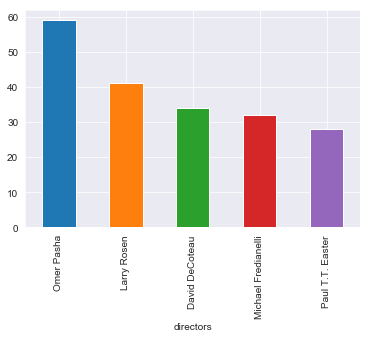

In [151]:
fun.groupby('directors')['movie'].count().sort_values(ascending=False).head(5).plot(kind='bar')

Next comes, the director who has churned the most money from his movies. In this category J.J. Abrams is a winner with 4 mega movies - Star Wars: The Force Awakens,Star Trek: Into Darkness,Super 8 and Star Trek. This guy has made 1.5 billion dollars from these 4 movies.

Below is a graph for top 5 directors in the above category.

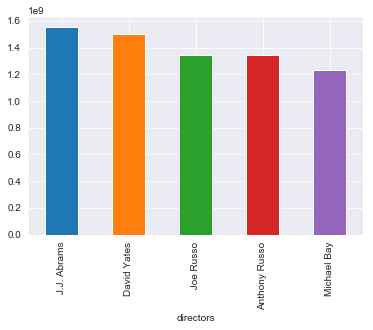

In [152]:
fun.groupby('directors')['gross'].sum().sort_values(ascending=False).head().plot(kind='bar')

In [153]:
fun[fun['directors']=='J.J. Abrams']

,certificate,directors,duration,genre,gross,metascore,movie,rating,stars,vote,year
20355,PG-13,J.J. Abrams,136,Action Adventure Fantasy,936662225,81.0,Star Wars: The Force Awakens,8.0,"Daisy Ridley, John Boyega, Oscar Isaac, Domhna...",766401,2015
32018,PG-13,J.J. Abrams,132,Action Adventure Sci-Fi,228778661,72.0,Star Trek: Into Darkness,7.7,"Chris Pine, Zachary Quinto, Zoe Saldana, Bened...",440537,2013
42882,PG-13,J.J. Abrams,112,Mystery Sci-Fi Thriller,127004179,72.0,Super 8,7.0,"Elle Fanning, AJ Michalka, Kyle Chandler, Joel...",316391,2011
51176,PG-13,J.J. Abrams,127,Action Adventure Sci-Fi,257730019,82.0,Star Trek,8.0,"Chris Pine, Zachary Quinto, Simon Pegg, Leonar...",550964,2009


Next, I was interested in finding out who is the most efficient money churning director, that is the guy who has made most money per movie. In this category James Cameroon with his single movie 'Avatar' is a winner. He has made 760 million dollar from a single movie. He is followed by Angus MacLane, Anthony Russo, Patty Jenkins and Jennifer Lee.

In [154]:
j=fun.groupby('directors')['gross'].sum().sort_values(ascending=False)
k=fun.groupby('directors')['movie'].count().sort_values(ascending=False)
l=pd.concat([j,k], axis=1)
m=l.drop(l[l['gross']==0].index)
m['money per movie']=m['gross'].divide(m['movie'])
m.reset_index(level=0, inplace=True)
n=m.sort_values('money per movie', ascending=False).head()
n

,index,gross,movie,money per movie
1244,James Cameron,760507625,1,760507625.0
24,Angus MacLane,486295561,1,486295561.0
483,Anthony Russo,1346666403,3,448888801.0
2049,Patty Jenkins,412563408,1,412563408.0
136,Jennifer Lee,400738009,1,400738009.0


Text(0.5,1,'Highly efficient directors')

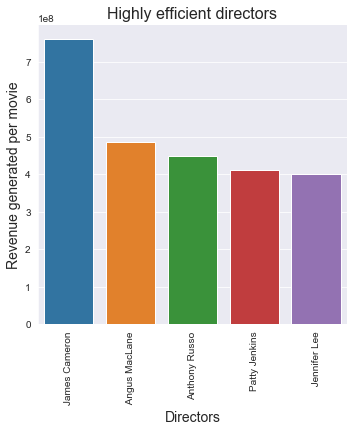

In [155]:
sns.catplot(y='money per movie', x='index',data=n, kind='bar')
plt.xticks(rotation=90)
plt.xlabel('Directors',fontsize=14)
plt.ylabel('Revenue generated per movie',fontsize=14)
plt.title('Highly efficient directors',fontsize=16)

In [156]:
fun[fun['directors']=='James Cameron']

,certificate,directors,duration,genre,gross,metascore,movie,rating,stars,vote,year
51242,PG-13,James Cameron,162,Action Adventure Fantasy,760507625,83.0,Avatar,7.8,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",1017917,2009


In [157]:
o=movies[movies['stars']!='Unknown']
o['stars']=o['stars'].str.split(',')
o.head(2)

,movie,year,genre,duration,certificate,directors,stars,rating,metascore,vote,gross,genre2
0,Hassan - The image of our common pain,2018,"[Drama, Family]",111,Unrated,Emaan,"[Leena Alam, Haroon Azizi, Hakim Diljo, Emaan]",10.0,0.0,5,0,Drama Family
1,Halt: The Motion Picture,2018,[Drama],110,Unrated,Jezar Riches,"[Harley Wallen, Andrew Dawe-Collins, Dennis ...",9.9,0.0,29,0,Drama


In [158]:
o=o.drop('genre', axis=1)
o['genre']=o['genre2']
o=o.drop('genre2', axis=1)
o.head(1)

,movie,year,duration,certificate,directors,stars,rating,metascore,vote,gross,genre
0,Hassan - The image of our common pain,2018,111,Unrated,Emaan,"[Leena Alam, Haroon Azizi, Hakim Diljo, Emaan]",10.0,0.0,5,0,Drama Family


In [159]:
movies_1=[]
years_1=[]
genres_1=[]
certificates_1=[]
star_1=[]
metascores_1=[]
votes_1=[]
duration_1=[]
rating_1=[]
director_1=[]
gross_1=[]
for _, row in o.iterrows():
    #print(row)
    moviey=row.movie
    yeary=row.year
    genrey=row.genre
    certificatey=row.certificate
    ratingy=row.rating
    metascorey=row.metascore
    votey=row.vote
    durationy=row.duration
    grossy=row.gross
    directorsy=row.directors
    #print(row.stars)
    for star in row.stars:
        movies_1.append(moviey)
        years_1.append(yeary)
        genres_1.append(genrey)
        certificates_1.append(certificatey)
        star_1.append(star)
        rating_1.append(ratingy)
        metascores_1.append(metascorey)
        votes_1.append(votey)
        gross_1.append(grossy)
        duration_1.append(durationy)
        director_1.append(directorsy)

fun2=pd.DataFrame({'movie':movies_1,'year':years_1,'certificate':certificates_1,'duration':duration_1, 'genre':genres_1,'rating':rating_1,'vote':votes_1, 'directors':director_1, 'stars':star_1,'metascore':metascores_1,'gross':gross_1})
fun2.head()

,certificate,directors,duration,genre,gross,metascore,movie,rating,stars,vote,year
0,Unrated,Emaan,111,Drama Family,0,0.0,Hassan - The image of our common pain,10.0,Leena Alam,5,2018
1,Unrated,Emaan,111,Drama Family,0,0.0,Hassan - The image of our common pain,10.0,Haroon Azizi,5,2018
2,Unrated,Emaan,111,Drama Family,0,0.0,Hassan - The image of our common pain,10.0,Hakim Diljo,5,2018
3,Unrated,Emaan,111,Drama Family,0,0.0,Hassan - The image of our common pain,10.0,Emaan,5,2018
4,Unrated,Jezar Riches,110,Drama,0,0.0,Halt: The Motion Picture,9.9,Harley Wallen,29,2018


In [160]:
fun2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174697 entries, 0 to 174696
Data columns (total 11 columns):
certificate    174697 non-null object
directors      174697 non-null object
duration       174697 non-null int64
genre          174697 non-null object
gross          174697 non-null int64
metascore      174697 non-null float64
movie          174697 non-null object
rating         174697 non-null float64
stars          174697 non-null object
vote           174697 non-null int64
year           174697 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 14.7+ MB


I found that this list contains 128908 stars

In [161]:
fun2['stars'].nunique()

128908

There seems to be some space before and after star's name. Therefore, I firsts tripped the whitespace.

In [162]:
fun2['stars']=fun2['stars'].str.strip()

The most acted star is Eric Roberts. He has acted in 125 movies.

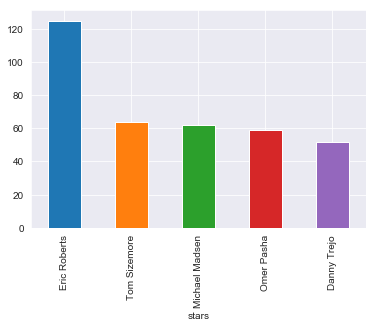

In [163]:
fun2.groupby('stars')['movie'].count().sort_values(ascending=False).head().plot(kind='bar')

In [164]:
fun2.groupby('stars')['movie'].count().sort_values(ascending=False).head()

stars
Eric Roberts      125
Tom Sizemore       64
Michael Madsen     62
Omer Pasha         59
Danny Trejo        52
Name: movie, dtype: int64

Lets check next, which star's movies have made the maximum money.

In [165]:
fun2.groupby('stars')['gross'].sum().sort_values(ascending=False).head()

stars
Robert Downey Jr.    3830758869
Dwayne Johnson       2773039122
Chris Evans          2706488135
Chris Pratt          2398661440
Jennifer Lawrence    2298474157
Name: gross, dtype: int64

Iron man-- Robert Downey Jr. beats everyone in this front. 

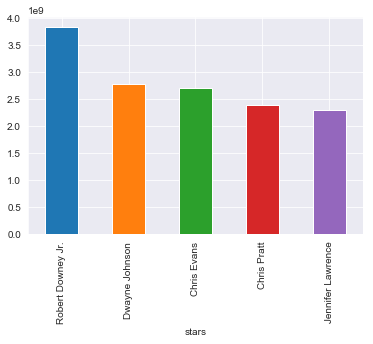

In [166]:
fun2.groupby('stars')['gross'].sum().sort_values(ascending=False).head().plot(kind='bar')

The next title for a star whose per movie gross is maximum goes to the Star Wars actress Daisy Ridley.

In [167]:
p=fun2.drop(fun2[fun2['gross']==0].index)
q=p.groupby('stars')['gross'].sum().sort_values(ascending=False)
r=p.groupby('stars')['movie'].count().sort_values(ascending=False)
s=pd.concat([q,r],axis=1)
s['money per movie']=s['gross'].divide(s['movie'])
s.reset_index(level=0, inplace=True)
t=s.sort_values('money per movie',ascending=False).head()
t

,index,gross,movie,money per movie
1487,Daisy Ridley,1556843607,2,778421803.5
6057,Sarah Vowell,608581744,1,608581744.0
2610,Huck Milner,608581744,1,608581744.0
3634,Kaitlin Olson,486295561,1,486295561.0
1991,Ellen DeGeneres,486295561,1,486295561.0


Text(0.5,1,'Highly efficient stars')

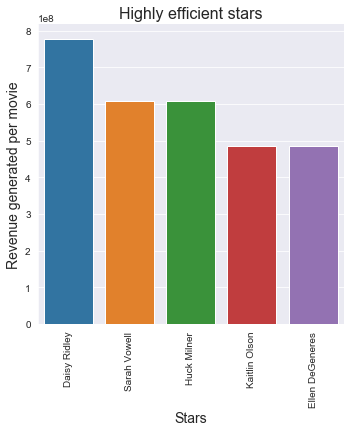

In [168]:
sns.catplot(y='money per movie', x='index',data=t, kind='bar')
plt.xticks(rotation=90)
plt.xlabel('Stars',fontsize=14)
plt.ylabel('Revenue generated per movie',fontsize=14)
plt.title('Highly efficient stars',fontsize=16)

In [169]:
p[p['stars']=='Daisy Ridley']

,certificate,directors,duration,genre,gross,metascore,movie,rating,stars,vote,year
24531,PG-13,Rian Johnson,152,Action Adventure Fantasy,620181382,85.0,Star Wars: Episode VIII - The Last Jedi,7.2,Daisy Ridley,437391,2017
62551,PG-13,J.J. Abrams,136,Action Adventure Fantasy,936662225,81.0,Star Wars: The Force Awakens,8.0,Daisy Ridley,766401,2015


Next, I tried building a predictive model for predicting revenue generated by a movie. For this I used the data for which 'gross' was available. 

In [235]:
data=pd.read_csv('movies_2.csv')
data=data[data['gross']!=0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3546 entries, 48 to 46983
Data columns (total 12 columns):
Unnamed: 0     3546 non-null int64
movie          3546 non-null object
year           3546 non-null int64
genre          3546 non-null object
duration       3546 non-null int64
certificate    3546 non-null object
directors      3546 non-null object
stars          3546 non-null object
rating         3546 non-null float64
metascore      3546 non-null float64
vote           3546 non-null int64
gross          3546 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 360.1+ KB


In [264]:
data['genre2']=data['genre'].str.split(', ')
data.head()

,Unnamed: 0,movie,year,genre,duration,certificate,directors,stars,rating,metascore,vote,gross,genre2
48,48,The Boys Are Back - Bandstand: The Broadway Mu...,2018,Musical,130,Unrated,"Lorenzo Thione, Matt Hoffman","Carleigh Bettiol, Mary Callanan, Joe Carroll, ...",9.2,0.0,45,855333,[Musical]
139,139,Spider-Man: Into the Spider-Verse,2018,"Animation, Action, Adventure",117,PG,"Bob Persichetti, Peter Ramsey, Rodney Rothman","Shameik Moore, Jake Johnson, Hailee Steinfeld,...",8.7,87.0,67264,133978231,"[Animation, Action, Adventure]"
193,193,Avengers: Infinity War,2018,"Action, Adventure, Fantasy",149,PG-13,"Anthony Russo, Joe Russo","Robert Downey Jr., Chris Hemsworth, Mark Ruffa...",8.5,68.0,561316,678815482,"[Action, Adventure, Fantasy]"
258,258,Bohemian Rhapsody,2018,"Biography, Drama, Music",134,PG-13,Bryan Singer,"Rami Malek, Lucy Boynton, Gwilym Lee, Ben Hardy",8.3,49.0,174303,193644966,"[Biography, Drama, Music]"
259,259,Green Book,2018,"Biography, Comedy, Drama",130,PG-13,Peter Farrelly,"Viggo Mortensen, Mahershala Ali, Linda Cardell...",8.3,70.0,16571,35230831,"[Biography, Comedy, Drama]"


In [265]:
# to get the list of the genre for each row into a One hot encoded form
mlb = MultiLabelBinarizer()
data2 = data.join(pd.DataFrame(mlb.fit_transform(data.pop('genre2')),
                          columns=mlb.classes_,
                          index=data.index))
data2.head()

,Unnamed: 0,movie,year,genre,duration,certificate,directors,stars,rating,metascore,vote,gross,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,Unknown,War,Western
48,48,The Boys Are Back - Bandstand: The Broadway Mu...,2018,Musical,130,Unrated,"Lorenzo Thione, Matt Hoffman","Carleigh Bettiol, Mary Callanan, Joe Carroll, ...",9.2,0.0,45,855333,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
139,139,Spider-Man: Into the Spider-Verse,2018,"Animation, Action, Adventure",117,PG,"Bob Persichetti, Peter Ramsey, Rodney Rothman","Shameik Moore, Jake Johnson, Hailee Steinfeld,...",8.7,87.0,67264,133978231,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
193,193,Avengers: Infinity War,2018,"Action, Adventure, Fantasy",149,PG-13,"Anthony Russo, Joe Russo","Robert Downey Jr., Chris Hemsworth, Mark Ruffa...",8.5,68.0,561316,678815482,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
258,258,Bohemian Rhapsody,2018,"Biography, Drama, Music",134,PG-13,Bryan Singer,"Rami Malek, Lucy Boynton, Gwilym Lee, Ben Hardy",8.3,49.0,174303,193644966,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
259,259,Green Book,2018,"Biography, Comedy, Drama",130,PG-13,Peter Farrelly,"Viggo Mortensen, Mahershala Ali, Linda Cardell...",8.3,70.0,16571,35230831,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [275]:
data3= data2.drop(['Unnamed: 0', 'movie','year', 'genre','duration','certificate','directors','stars','Unknown'], axis=1)
data3.shape

(3546, 24)

In [276]:
x=data3.drop('gross', axis=1)
X=x.values
y=data3['gross']

Used RandomForestRegressor to build a model. Hyperparameter tuning was also done. The low R2 score and hig RMSE could be due to a small data size and not all determining features available for this analysis such as the budget of the movie, etc.

In [278]:
forest_model = RandomForestRegressor(random_state=21)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=21)
rmse= np.sqrt(np.mean(-cross_val_score(forest_model, train_X, train_y,cv=3,  scoring='neg_mean_squared_error')))
print("RMSE : %f" % (rmse))
r2_score1= np.mean(cross_val_score(forest_model, train_X, train_y,cv=5,  scoring='r2'))
print("R2 score: %s" % '{:.2}'.format(r2_score1))

RMSE : 42245586.153561
R2 score: 0.64


In [270]:
param_grid = {'max_depth': [10, 20, 60],
              'max_features': ['auto','sqrt'],
              'min_samples_leaf': [1, 3, 5],
              'min_samples_split': [2, 4, 8],
              'n_estimators': [100, 500, 1000],
             'bootstrap': [False, True]}
# Create a base model
rf = RandomForestRegressor(random_state=21)
# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 0)
rf_grid.fit(train_X, train_y)
print(rf_grid.best_params_)


{'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [283]:
rf_cv_grid=RandomForestRegressor(random_state=21,n_estimators= 500, min_samples_split= 2, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 20, bootstrap= True)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=21)
rf_cv_grid.fit(train_X,train_y )
predictions=rf_cv_grid.predict(test_X)
rmse3 = np.sqrt(mean_squared_error(test_y, predictions))
print("RMSE : %f" % (rmse3))
r23= r2_score(test_y,predictions)
print("R2 score: %s" % '{:.2}'.format(r23))

RMSE : 40582962.327138
R2 score: 0.64


Next obtained importance of features for determining revenue of a movie. 

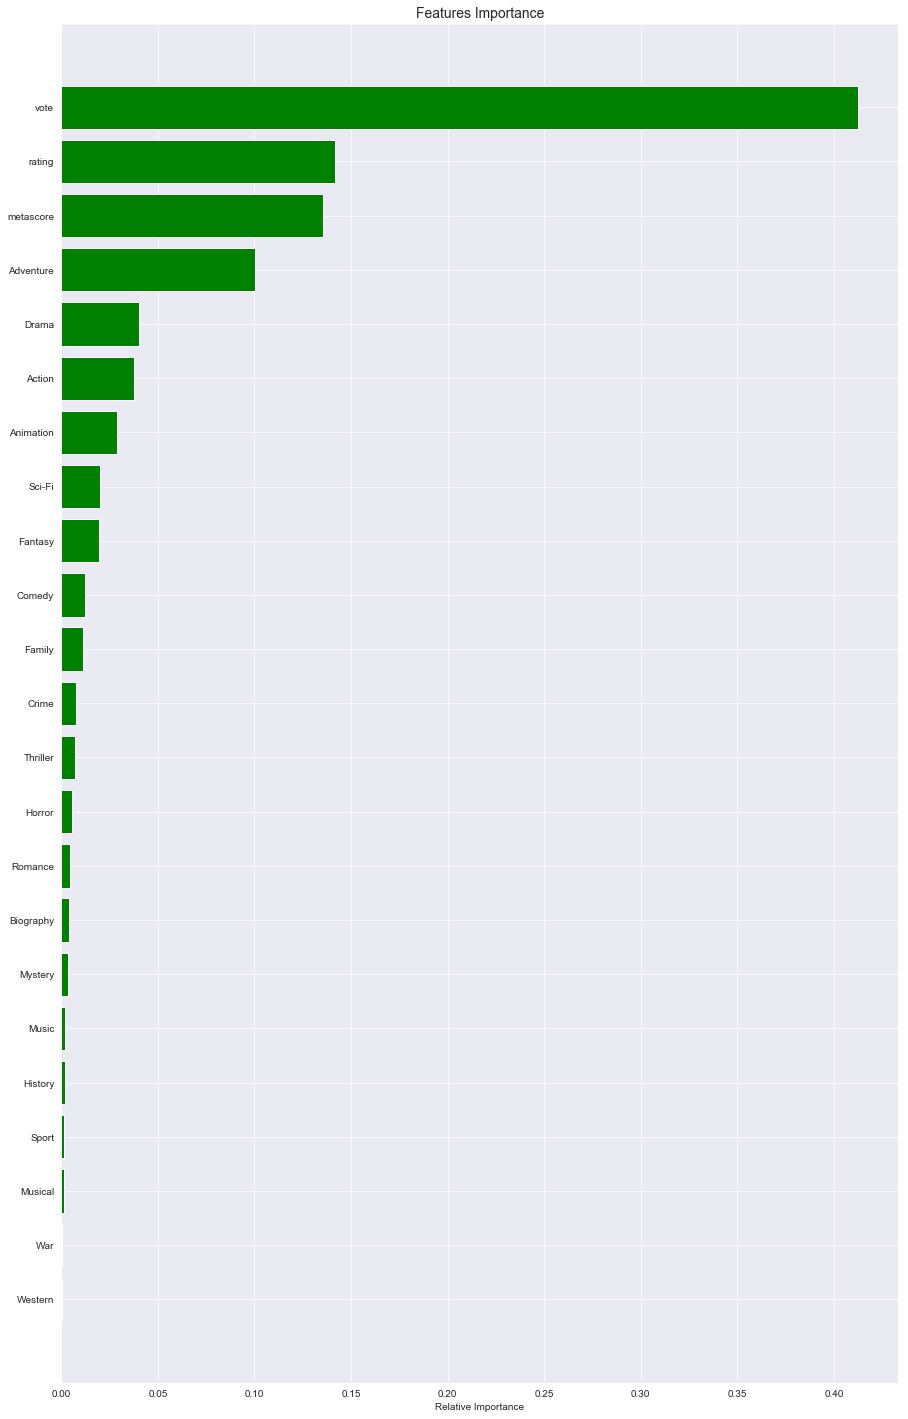

In [295]:
rf_cv_grid.fit(train_X, train_y)
fig, ax=plt.subplots(figsize=(15,25))
features = x.columns
importances = rf_cv_grid.feature_importances_
indices = np.argsort(importances)

plt.title('Features Importance', fontsize=14)
plt.barh(range(len(indices)), importances[indices], color='green', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show() 

